In [ ]:
from google.colab import drive
drive.mount('/content/drive')

base_path = "/content/drive/MyDrive/Colab Notebooks/Final Project/archive"
train_dir = f"{base_path}/train"
val_dir = f"{base_path}/validation"
test_dir = f"{base_path}/test"


Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model, load_model, Sequential
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization

In [ ]:
import os

# Specify the path to your dataset
fpath = train_dir
dataset_path = fpath

# Get a list of subdirectories (each subdirectory corresponds to a class)
class_folders = [f.name for f in os.scandir(dataset_path) if f.is_dir()]

# Get the number of classes
num_classes = len(class_folders)

# Print the number of classes
print("Number of classes:", num_classes)

# Create a list of target_names based on the directory names
target_names = class_folders
print("Target Names:", target_names)


Number of classes: 2
Target Names: ['nike', 'adidas']


In [ ]:
img_size = 224
batch_size =100
fpath = train_dir
ffpath = test_dir
fffpath = val_dir


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Assuming 'fpath' is the path to your dataset and 'batch_size' is defined

datagen = ImageDataGenerator(
    rescale=1/255.,
    zoom_range=0.2,
    rotation_range=30,
    horizontal_flip=True
)

train_gen = datagen.flow_from_directory(
    fpath,
    target_size=(224, 224),
    subset="training",
    class_mode='categorical',
    batch_size=batch_size
)

valid_gen = datagen.flow_from_directory(
    fffpath,
    target_size=(224, 224),
    batch_size=(batch_size),
    subset='training',
    class_mode='categorical'
)

# For test data
test_gen = ImageDataGenerator(rescale=1/255.).flow_from_directory(
    ffpath,
    target_size=(224, 224), # 將影像大小調整為 224x224（與模型輸入一致）
    batch_size=100,
    class_mode='categorical', # 分類模式，適用於多類別分類問題
    shuffle=False  # 測試資料不要隨機打亂，保證預測結果與真實標籤順序對應
)

Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# 取得圖片大小與類別數
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# 建立預訓練模型骨幹（EfficientNetB3）
base_model = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([  # 建立完整的分類模型
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

# 編譯模型
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# 設定模型保存機制
filepath = 'best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# 開始訓練模型
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
3/5 ━━━━━━━━━━━━━━━━━━━━ 13s 7s/step - accuracy: 0.5322 - loss: 1.1512  

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.5242 - loss: 1.1851 
Epoch 1: val_accuracy improved from -inf to 0.49091, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 151s 22s/step - accuracy: 0.5223 - loss: 1.1923 - val_accuracy: 0.4909 - val_loss: 1.5526
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4809 - loss: 1.1032
Epoch 2: val_accuracy improved from 0.49091 to 0.50909, saving model to best_model.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.4844 - loss: 1.0996 - val_accuracy: 0.5091 - val_loss: 3.9117
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5107 - loss: 1.1275
Epoch 3: val_accuracy did not improve from 0.50909
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5089 - loss: 1.1163 - val_accuracy: 0.4909 - val_loss: 1.9600
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4734 - loss: 1.0412
Epoch 4: val_accuracy did not improve from 0.50909
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.4731 - loss: 1.0372 - val_accuracy: 0.5091 - val_loss: 0.9485
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5419 - loss: 0.8561
Epoch 5: val_accuracy did not improve from 0.50909
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.5346 - loss: 0.8646 - val_accuracy: 0.4909 - val_loss: 0.8430
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5193 - loss: 0.8525
Epoch 6: val_accuracy did not improve from 0.50909
5/5 ━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model.h5')

train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 3s/step - accuracy: 0.4885 - loss: 4.4224
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.5091 - loss: 4.2434
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step - accuracy: 0.5000 - loss: 4.3268
Train Loss:  4.322319030761719
Train Accuracy:  0.5
--------------------
Validation Loss:  4.243374824523926
Validation Accuracy:  0.5090909004211426
--------------------
Test Loss:  4.326838970184326
Test Accuracy:  0.5


In [ ]:
model = load_model('best_model.h5')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [ ]:
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
    plt.figure(figsize= (10, 10))
    plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation= 45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
        print('Normalized Confusion Matrix')
    else:
        print('Confusion Matrix, Without Normalization')
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

Confusion Matrix, Without Normalization
[[ 0 30]
 [ 0 30]]
              precision    recall  f1-score   support

        nike       0.00      0.00      0.00        30
      adidas       0.50      1.00      0.67        30

    accuracy                           0.50        60
   macro avg       0.25      0.50      0.33        60
weighted avg       0.25      0.50      0.33        60



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


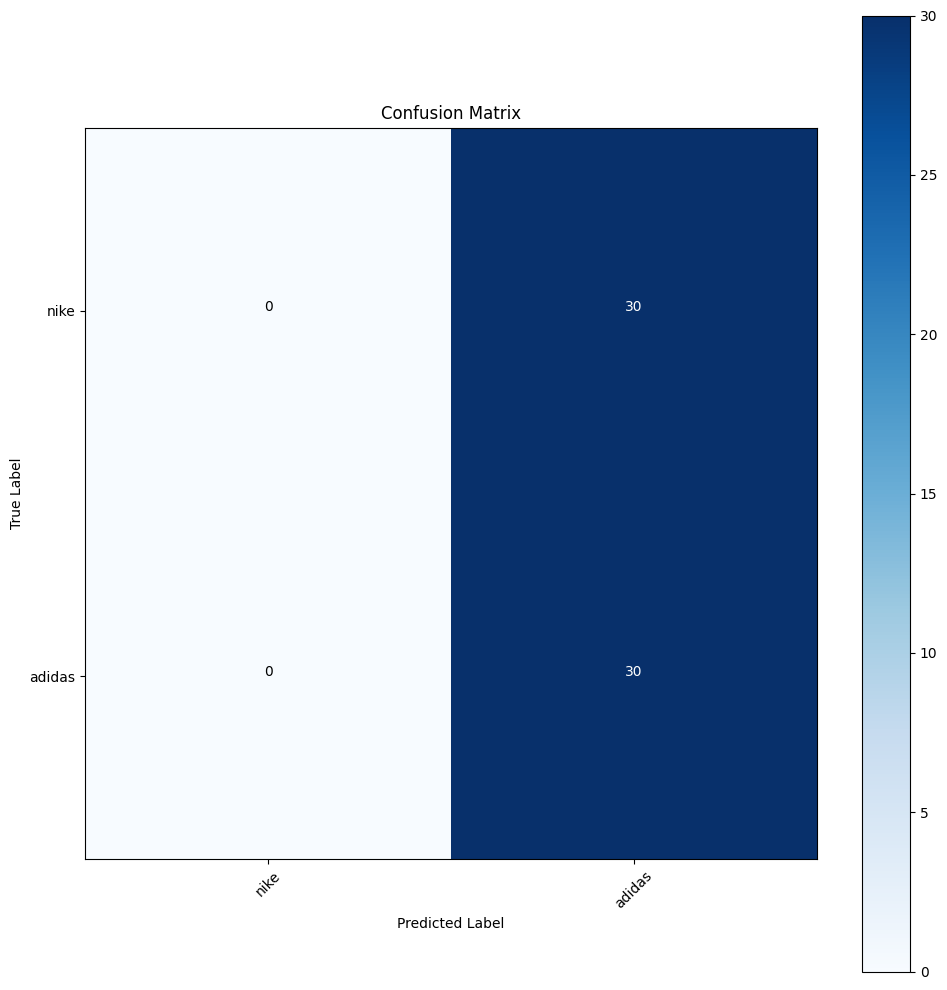

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.ResNet50(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_resnet.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5138 - loss: 0.8645
Epoch 1: val_accuracy improved from -inf to 0.50909, saving model to best_model_resnet.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 48s 6s/step - accuracy: 0.5195 - loss: 0.8598 - val_accuracy: 0.5091 - val_loss: 0.9013
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6296 - loss: 0.6868
Epoch 2: val_accuracy improved from 0.50909 to 0.54545, saving model to best_model_resnet.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.6297 - loss: 0.6849 - val_accuracy: 0.5455 - val_loss: 0.6919
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6698 - loss: 0.6356
Epoch 3: val_accuracy did not improve from 0.54545
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.6702 - loss: 0.6341 - val_accuracy: 0.4909 - val_loss: 0.7689
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6556 - loss: 0.6535
Epoch 4: val_accuracy did not improve from 0.54545
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6580 - loss: 0.6472 - val_accuracy: 0.4909 - val_loss: 0.7746
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7109 - loss: 0.5784
Epoch 5: val_accuracy did not improve from 0.54545
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7113 - loss: 0.5782 - val_accuracy: 0.4727 - val_loss: 0.7878
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6714 - loss: 0.6181
Epoch 6: val_accuracy did not improve from 0.54545
5/5 ━━━━━━━━━━━━━━━━

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7539 - loss: 0.4626 - val_accuracy: 0.6545 - val_loss: 0.6411
Epoch 13/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7818 - loss: 0.4851
Epoch 13: val_accuracy did not improve from 0.65455
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7819 - loss: 0.4854 - val_accuracy: 0.6364 - val_loss: 0.6487
Epoch 14/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7662 - loss: 0.4621
Epoch 14: val_accuracy did not improve from 0.65455
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7642 - loss: 0.4650 - val_accuracy: 0.6545 - val_loss: 0.6400
Epoch 15/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7698 - loss: 0.4710
Epoch 15: val_accuracy improved from 0.65455 to 0.70909, saving model to best_model_resnet.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7705 - loss: 0.4725 - val_accuracy: 0.7091 - val_loss: 0.5831
Epoch 16/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7690 - loss: 0.4774
Epoch 16: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.7698 - loss: 0.4748 - val_accuracy: 0.6364 - val_loss: 0.6636
Epoch 17/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7860 - loss: 0.4768
Epoch 17: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7836 - loss: 0.4768 - val_accuracy: 0.5818 - val_loss: 0.6382
Epoch 18/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7772 - loss: 0.4437
Epoch 18: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.7781 - loss: 0.4432 - val_accuracy: 0.6000 - val_loss: 0.6227
Epoch 19/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7747 - loss: 0.4719
Epoch 19: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_resnet.h5')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7035 - loss: 0.6076
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.7455 - loss: 0.5940
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step - accuracy: 0.6000 - loss: 0.6422
Train Loss:  0.5959060192108154
Train Accuracy:  0.7130434513092041
--------------------
Validation Loss:  0.5940325856208801
Validation Accuracy:  0.7454545497894287
--------------------
Test Loss:  0.6421598196029663
Test Accuracy:  0.6000000238418579


In [ ]:
model = load_model('best_model_resnet.h5')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
[1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 1 0 1 1 0 0 0 1 1 1 0 1 1 0 1 1 1 1 1
 1 0 1 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1]


Confusion Matrix, Without Normalization
[[15 15]
 [ 9 21]]
              precision    recall  f1-score   support

        nike       0.62      0.50      0.56        30
      adidas       0.58      0.70      0.64        30

    accuracy                           0.60        60
   macro avg       0.60      0.60      0.60        60
weighted avg       0.60      0.60      0.60        60



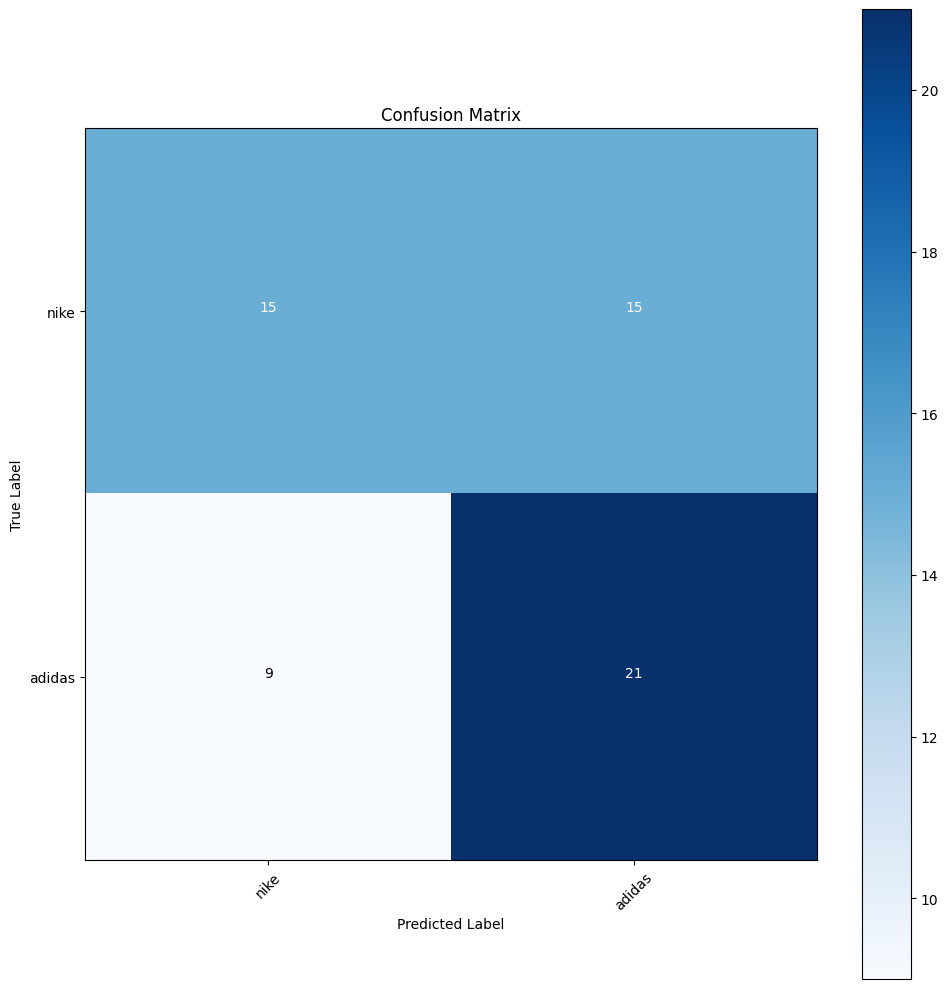

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming train_gen and valid_gen are your image data generators

img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

# Create pre-trained model
base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_shape=img_shape, pooling='max')
for layer in base_model.layers:
    layer.trainable = False
model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
     Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(class_count, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define filepath to save the best model
filepath = 'best_model_vgg.h5'

# Create ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# Train the model with the added callback
history = model.fit(
    x=train_gen,
    epochs=20,
    verbose=1,
    validation_data=valid_gen,
    callbacks=[checkpoint]
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.4992 - loss: 0.9691
Epoch 1: val_accuracy improved from -inf to 0.54545, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 73s 10s/step - accuracy: 0.5087 - loss: 0.9521 - val_accuracy: 0.5455 - val_loss: 0.7445
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6561 - loss: 0.6671
Epoch 2: val_accuracy improved from 0.54545 to 0.70909, saving model to best_model_vgg.h5


5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.6620 - loss: 0.6618 - val_accuracy: 0.7091 - val_loss: 0.5702
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7215 - loss: 0.5639
Epoch 3: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7262 - loss: 0.5552 - val_accuracy: 0.6364 - val_loss: 0.5526
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8143 - loss: 0.4240
Epoch 4: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8130 - loss: 0.4286 - val_accuracy: 0.6909 - val_loss: 0.6006
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8022 - loss: 0.4506
Epoch 5: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.8033 - loss: 0.4464 - val_accuracy: 0.7091 - val_loss: 0.5472
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8480 - loss: 0.3689
Epoch 6: val_accuracy did not improve from 0.70909
5/5 ━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average



model= load_model('best_model_vgg.h5')


train_score = model.evaluate(train_gen, steps= len(train_gen), verbose= 1)
valid_score = model.evaluate(valid_gen, steps= len(valid_gen), verbose= 1)
test_score = model.evaluate(test_gen, steps= len(test_gen), verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 0.7667 - loss: 0.5315
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7091 - loss: 0.5711
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step - accuracy: 0.6500 - loss: 0.5756
Train Loss:  0.5371361374855042
Train Accuracy:  0.760869562625885
--------------------
Validation Loss:  0.5710840821266174
Validation Accuracy:  0.7090908885002136
--------------------
Test Loss:  0.5756226181983948
Test Accuracy:  0.6499999761581421


In [ ]:
model = load_model('best_model_vgg.h5')
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
[1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 0 1 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


Confusion Matrix, Without Normalization
[[12 18]
 [ 3 27]]
              precision    recall  f1-score   support

        nike       0.80      0.40      0.53        30
      adidas       0.60      0.90      0.72        30

    accuracy                           0.65        60
   macro avg       0.70      0.65      0.63        60
weighted avg       0.70      0.65      0.63        60



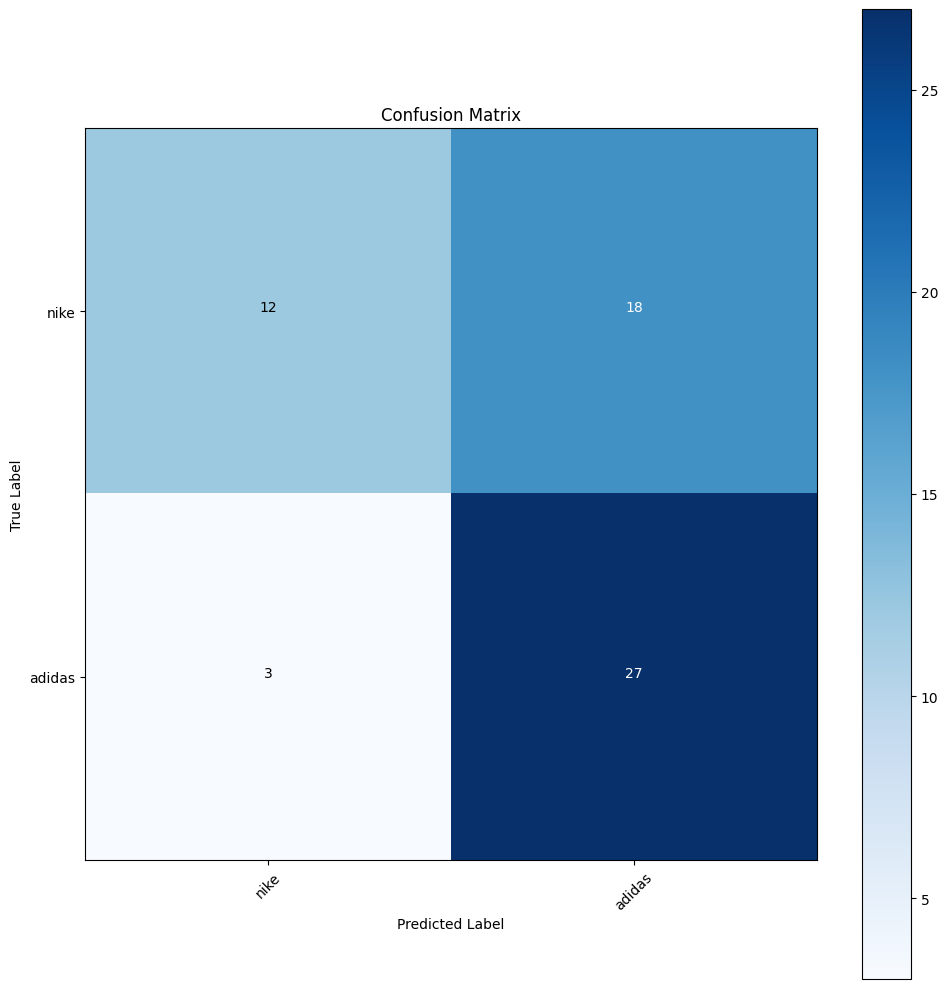

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)
plot_confusion_matrix(cm= cm, classes= target_names, title = 'Confusion Matrix')
# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= target_names))

In [ ]:
# 匯入必要模組
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# 設定資料路徑
train_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/archive/train"
val_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/archive/validation"
img_size = (224, 224)
batch_size = 32

# 建立 ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# 取得類別名稱
target_names = list(train_generator.class_indices.keys())
num_classes = len(target_names)

# 建立模型函式
def build_model(base_model_fn, input_shape=(224, 224, 3), num_classes=3):
    base_model = base_model_fn(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 訓練所有模型並儲存
model_names = ["VGG16", "ResNet50", "EfficientNetB0"]
model_fns = [VGG16, ResNet50, EfficientNetB0]
histories = []
accuracies = []

for name, fn in zip(model_names, model_fns):
    print(f"\nTraining {name}...")
    model = build_model(fn, num_classes=num_classes)
    history = model.fit(train_generator,validation_data=val_generator,epochs=5,verbose=1)
    acc = max(history.history["val_accuracy"])
    histories.append(history)
    accuracies.append(acc)
    model.save(f"/content/drive/MyDrive/Colab Notebooks/Final Project/{name}_model.h5")
    print(f"{name} saved. Best Val Acc: {acc:.4f}")


Found 460 images belonging to 2 classes.
Found 55 images belonging to 2 classes.

Training VGG16...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.5422 - loss: 0.7625 - val_accuracy: 0.6000 - val_loss: 0.6782
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 228ms/step - accuracy: 0.5199 - loss: 0.7295 - val_accuracy: 0.5818 - val_loss: 0.6681
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 234ms/step - accuracy: 0.5841 - loss: 0.7237 - val_accuracy: 0.7455 - val_loss: 0.6586
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 243ms/step - accuracy: 0.5880 - loss: 0.6702 - val_accuracy: 0.8000 - val_loss: 0.6511
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.6413 - loss: 0.6325 - val_accuracy: 0.6909 - val_loss: 0.6417


VGG16 saved. Best Val Acc: 0.8000

Training ResNet50...
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.4810 - loss: 0.8313 - val_accuracy: 0.5091 - val_loss: 0.6776
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 204ms/step - accuracy: 0.5312 - loss: 0.7241 - val_accuracy: 0.7273 - val_loss: 0.6658
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.5320 - loss: 0.7198 - val_accuracy: 0.7455 - val_loss: 0.6622
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 201ms/step - accuracy: 0.5571 - loss: 0.7141 - val_accuracy: 0.7636 - val_loss: 0.6560
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - accuracy: 0.5318 - loss: 0.7017 - val_accuracy: 0.6000 - val_loss: 0.6538


ResNet50 saved. Best Val Acc: 0.7636

Training EfficientNetB0...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 54s 2s/step - accuracy: 0.4984 - loss: 0.7333 - val_accuracy: 0.4909 - val_loss: 0.6936
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 219ms/step - accuracy: 0.5259 - loss: 0.7010 - val_accuracy: 0.4909 - val_loss: 0.6940
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step - accuracy: 0.4777 - loss: 0.7065 - val_accuracy: 0.5091 - val_loss: 0.6943
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 203ms/step - accuracy: 0.5202 - loss: 0.7216 - val_accuracy: 0.5091 - val_loss: 0.6934
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 202ms/step - accuracy: 0.5221 - loss: 0.7054 - val_accuracy: 0.4909 - val_loss: 0.6953


EfficientNetB0 saved. Best Val Acc: 0.5091


Best model: VGG16 with acc 0.8000


Found 60 images belonging to 2 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 11s 10s/step

Classification Report:
              precision    recall  f1-score   support

      adidas       0.79      0.50      0.61        30
        nike       0.63      0.87      0.73        30

    accuracy                           0.68        60
   macro avg       0.71      0.68      0.67        60
weighted avg       0.71      0.68      0.67        60



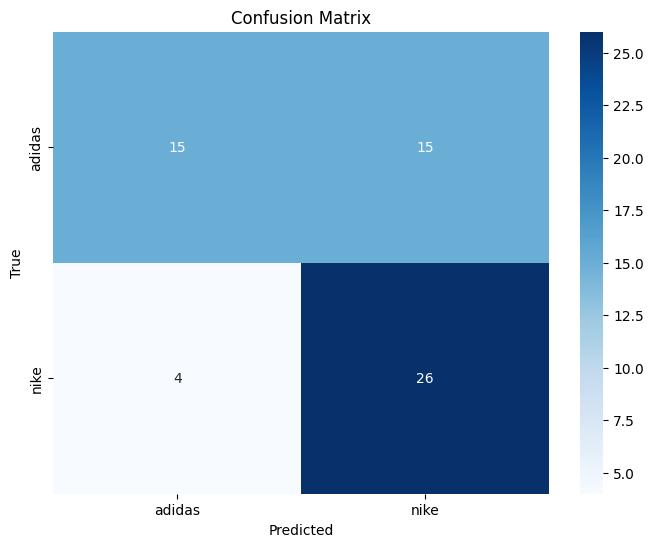

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 選出最佳模型
best_idx = np.argmax(accuracies)
best_model_name = model_names[best_idx]
print(f"Best model: {best_model_name} with acc {accuracies[best_idx]:.4f}")

# 載入最佳模型
best_model = load_model(f"/content/drive/MyDrive/Colab Notebooks/Final Project/{best_model_name}_model.h5")

test_dir = "/content/drive/MyDrive/Colab Notebooks/Final Project/archive/test"
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # 非常重要，保證 y_true 的順序正確
)

# 預測測試集
test_generator.reset()
pred_probs = best_model.predict(test_generator, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

# 分類報告
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=target_names))

# 混淆矩陣
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import os

# 設定圖片所在資料夾路徑
image_folder_path = "/content/drive/MyDrive/Colab Notebooks/Final Project/new input"
image_files = [f"shoes{i:02d}.jpg" for i in range(1, 31)]  # shoes01.jpg 到 shoes30.jpg

# 載入最佳模型（VGG16）
model = load_model('/content/drive/MyDrive/Colab Notebooks/Final Project/VGG16_model.h5')

# 預設 target_names (根據實際的類別設定)
target_names = ['adidas', 'nike']  # 根據你的實際類別調整

# 預測每一張圖片
for img_file in image_files:
    img_path = os.path.join(image_folder_path, img_file)

    img = image.load_img(img_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Input Image: {img_file}")
    plt.show()

    # 預處理
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # 正規化

    # 預測
    pred = model.predict(img_array)
    pred_class = np.argmax(pred, axis=1)[0]

    # 輸出預測結果
    print(f"預測結果：{img_file} -> 這雙鞋是【{target_names[pred_class]}】品牌")


Output hidden; open in https://colab.research.google.com to view.